# **Boulder urban forest traits project**
## Public Tree Inventory - Exploratory Analysis

In [102]:
import os
import cartopy.crs as ccrs
import earthpy as et
import earthpy.appeears as etapp
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hvplot.pandas
import hvplot.xarray
import hvplot
# import geoviews as gv
import rasterio
import rioxarray as rxr
import requests
import xarray as xr


In [2]:
project_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'urban-forest-traits')
data_dir = os.path.join(project_dir, 'data')

for a_dir in [project_dir, data_dir]:
    if not os.path.exists(a_dir):
        os.makedirs(a_dir)

In [3]:
!ls $project_dir

data             species_list.csv


### Download data

In [10]:
# Download public tree inventory data

print("Checking if data is downloaded...")
public_tree_path = os.path.join(project_dir, data_dir, 'public_trees.geojson')

if os.path.exists(public_tree_path):
    
    trees_gdf = gpd.read_file(public_tree_path)
    print("Data is already downloaded.")
    
else:
    print("Data is not downloaded. Initiating download...")

    # Define URL
    public_trees_all_url = (
        'https://gis.bouldercolorado.gov/ags_svr2/rest/services/'
        'parks/TreesOpenData/MapServer/0/query?'
        'where=1%3D1&outFields=*&returnGeometry=false'
        '&returnIdsOnly=true&outSR=4326&f=json'
    )

    # Mimic web browser
    user_agent = (
        'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
        'Gecko/20100101 Firefox/81.0'
    )

    # Download GEOJSON
    r = requests.get(url=public_trees_all_url, headers={'User-Agent': user_agent})
    geojson_data = r.json()

    # Extract the objectIDs (the indexes of the rows in the dataset)
    objectid_list = geojson_data["objectIds"]

    # Define chunks from the row numbers
    chunks = [
        (objectid_list[i],
            objectid_list[min(i + 1000,
                                len(objectid_list)-1)])
        for i in range(0, len(objectid_list), 1000)
    ]
    print("Data chunks identified.")

    # # Due to the City of Boulder ArcGIS Hub limit of downloading
    # # a maximum of 2,000 items at a time,
    # # split the dataset into chunks and download the chunks individually.

    # # Download data for each chunk
    all_chunks_list = []
    for (min_objectid, max_objectid) in chunks:

        # Define url
        public_trees_object_ids_url = (
            'https://gis.bouldercolorado.gov/ags_svr2/rest/services/'
            'parks/TreesOpenData/MapServer/0/query?'
            "where=OBJECTID%20%3E%3D%20{min_objectid}"
            "%20AND%20OBJECTID%20%3C%3D%20{max_objectid}"
            "&outFields=*&outSR=4326&f=geojson"
        )

        # Download chunk of data
        r = requests.get(url=public_trees_object_ids_url.format(
            min_objectid=min_objectid,
            max_objectid=max_objectid),
            headers={'User-Agent': user_agent})

        # Read GeoJSON data into a GeoDataFrame
        geojson_data = r.json()
        chunk_gdf = (gpd.GeoDataFrame
                            .from_features(geojson_data['features'])
        )
        all_chunks_list.append(chunk_gdf)

    # Concatenate the chunk gdfs into one gdf
    public_trees_all_gdf = pd.concat(all_chunks_list)

    # Save downloaded data to CSV in directory
    public_trees_all_gdf.to_file(public_tree_path, driver='GeoJSON', crs="EPSG:4326")

    trees_gdf = gpd.read_file(public_tree_path)

Checking if data is downloaded...
Data is already downloaded.


In [11]:
trees_gdf.head()

,OBJECTID,FACILITYID,SPECIESCD,FULLNAME,LATINNAME,GENUS,CULTIVAR,COMMONNAME,GENUSCOM,LEAFCYCLE,...,OWNEDBY,TREEDIST,GLOBALID,PROPNAME,CONFIDENCE,DATACONF,DIVERSITYINDEX,SPECIESINDEX,OTHERINDEX,geometry
0,1,TREE79142,FRPE,Fraxinus pennsylvanica,Fraxinus pennsylvanica,Fraxinus,None,"Ash, Green",Ash,Deciduous,...,City,Northeast Boulder,{511B97EE-A1CF-49D3-8EE8-6897D4ABF868},None,None,None,None,None,None,POINT (-105.22100 40.02395)
1,2,TREE79143,FRPE,Fraxinus pennsylvanica,Fraxinus pennsylvanica,Fraxinus,None,"Ash, Green",Ash,Deciduous,...,City,Northeast Boulder,{EB01B286-7B24-4A2D-ABD6-C3CAC41F34D1},None,None,None,None,None,None,POINT (-105.22103 40.02378)
2,3,TREE79144,CASP,Catalpa speciosa,Catalpa speciosa,Catalpa,None,"Catalpa, Western",Catalpa,Deciduous,...,City,Northeast Boulder,{75239CC6-6A21-4FAF-93D0-FDB3680FBC15},None,None,None,None,None,None,POINT (-105.22109 40.02361)
3,4,TREE79145,CASP,Catalpa speciosa,Catalpa speciosa,Catalpa,None,"Catalpa, Western",Catalpa,Deciduous,...,City,Northeast Boulder,{D7616678-C732-4EA5-8560-5B9B100FD520},None,None,None,None,None,None,POINT (-105.22116 40.02349)
4,5,TREE79146,FRAM,Fraxinus americana,Fraxinus americana,Fraxinus,None,"Ash, White",Ash,Deciduous,...,City,Northeast Boulder,{A21FA763-98E8-45C9-8BEE-7B7246EB70D1},None,None,None,None,None,None,POINT (-105.22174 40.02329)


In [13]:
# Find the trees with no geometry
trees_gdf.iloc[[44304, 44555]]

,OBJECTID,FACILITYID,SPECIESCD,FULLNAME,LATINNAME,GENUS,CULTIVAR,COMMONNAME,GENUSCOM,LEAFCYCLE,...,OWNEDBY,TREEDIST,GLOBALID,PROPNAME,CONFIDENCE,DATACONF,DIVERSITYINDEX,SPECIESINDEX,OTHERINDEX,geometry
44304,46109,TREE87754,MASY2,Malus x Spring Snow,Malus x Spring Snow,Malus,Spring Snow,"Crabapple, Spring Snow",Apple or Crabapple,Deciduous,...,City,Northeast Broadway,{5F43EABF-F3C6-4903-B213-76EBA6E87BDA},None,None,None,None,None,None,None
44555,46364,TREE87706,MASY2,Malus x Spring Snow,Malus x Spring Snow,Malus,Spring Snow,"Crabapple, Spring Snow",Apple or Crabapple,Deciduous,...,City,Iris,{F86281D1-76B3-43D4-8FB4-7B15DF1516D9},None,None,None,None,None,None,None


In [17]:
# Download parks in Boulder polygons

parks_url = 'https://gis.bouldercolorado.gov/ags_svr2/rest/services/parks/ParkSitesOpenData/MapServer/1/query?outFields=*&where=1%3D1&f=geojson'

response = requests.get(parks_url,
                        headers={'User-Agent': user_agent})
parks_data = response.json()

parks_gdf = gpd.GeoDataFrame.from_features(parks_data['features'])
parks_gdf.crs = "EPSG:4326"

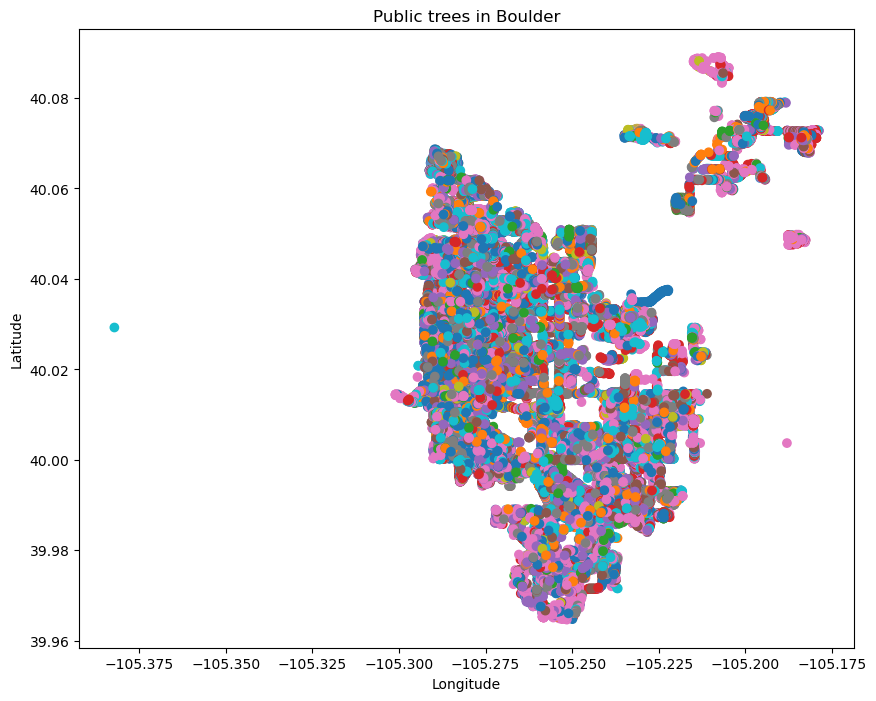

In [19]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# You can choose a column to color the plot, let's say 'population'
trees_gdf.plot(column='GENUS', ax=ax, legend=False)

# Add title and labels
plt.title('Public trees in Boulder')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [23]:
# Clean the tree inventory data for plotting

trees_names_gdf = trees_gdf

# Remove non_strings
non_string_mask = trees_names_gdf['LATINNAME'].apply(lambda x: not isinstance(x, str))
trees_names_gdf = trees_names_gdf[~non_string_mask]
trees_names_gdf['LATINNAME_str'] = trees_names_gdf['LATINNAME'].astype(str)

trees_names_gdf.dtypes

# Are there trees with no geometry?
print(trees_gdf.geom_type[trees_gdf.geom_type != 'Point'])


44304    None
44555    None
dtype: object


/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
# Drop trees with NA for geometry
trees_dropped_gdf = trees_gdf.dropna(subset = ['geometry'])

trees_dropped_gdf.head()


,OBJECTID,FACILITYID,SPECIESCD,FULLNAME,LATINNAME,GENUS,CULTIVAR,COMMONNAME,GENUSCOM,LEAFCYCLE,...,OWNEDBY,TREEDIST,GLOBALID,PROPNAME,CONFIDENCE,DATACONF,DIVERSITYINDEX,SPECIESINDEX,OTHERINDEX,geometry
0,1,TREE79142,FRPE,Fraxinus pennsylvanica,Fraxinus pennsylvanica,Fraxinus,None,"Ash, Green",Ash,Deciduous,...,City,Northeast Boulder,{511B97EE-A1CF-49D3-8EE8-6897D4ABF868},None,None,None,None,None,None,POINT (-105.22100 40.02395)
1,2,TREE79143,FRPE,Fraxinus pennsylvanica,Fraxinus pennsylvanica,Fraxinus,None,"Ash, Green",Ash,Deciduous,...,City,Northeast Boulder,{EB01B286-7B24-4A2D-ABD6-C3CAC41F34D1},None,None,None,None,None,None,POINT (-105.22103 40.02378)
2,3,TREE79144,CASP,Catalpa speciosa,Catalpa speciosa,Catalpa,None,"Catalpa, Western",Catalpa,Deciduous,...,City,Northeast Boulder,{75239CC6-6A21-4FAF-93D0-FDB3680FBC15},None,None,None,None,None,None,POINT (-105.22109 40.02361)
3,4,TREE79145,CASP,Catalpa speciosa,Catalpa speciosa,Catalpa,None,"Catalpa, Western",Catalpa,Deciduous,...,City,Northeast Boulder,{D7616678-C732-4EA5-8560-5B9B100FD520},None,None,None,None,None,None,POINT (-105.22116 40.02349)
4,5,TREE79146,FRAM,Fraxinus americana,Fraxinus americana,Fraxinus,None,"Ash, White",Ash,Deciduous,...,City,Northeast Boulder,{A21FA763-98E8-45C9-8BEE-7B7246EB70D1},None,None,None,None,None,None,POINT (-105.22174 40.02329)


In [26]:
trees_names_gdf = trees_dropped_gdf

# Remove non_strings
non_string_mask = trees_names_gdf['LATINNAME'].apply(lambda x: not isinstance(x, str))
trees_names_gdf = trees_names_gdf[~non_string_mask]
# trees_names_gdf['LATINNAME_str'] = trees_names_gdf['LATINNAME'].astype(str)

trees_names_gdf.dtypes

OBJECTID             int64
FACILITYID          object
SPECIESCD           object
FULLNAME            object
LATINNAME           object
GENUS               object
CULTIVAR            object
COMMONNAME          object
GENUSCOM            object
LEAFCYCLE           object
LEAFTYPE            object
DBHINT             float64
NOTETREE            object
PROJECT             object
ADDRESS             object
ZIPCODE             object
ONSTREET            object
LOCTYPE             object
SITETYPE            object
MAINTBY             object
OWNEDBY             object
TREEDIST            object
GLOBALID            object
PROPNAME            object
CONFIDENCE          object
DATACONF            object
DIVERSITYINDEX      object
SPECIESINDEX        object
OTHERINDEX          object
geometry          geometry
dtype: object

In [27]:
trees_plot = trees_names_gdf.hvplot(
    geo=True,
    tiles='EsriImagery',
    alpha =0.5,
    size=10,
    hover_cols='GENUS',
    c='GENUS',
    legend=False
)

trees_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (GENUS)

In [42]:
parks_plot = parks_gdf.hvplot(
    geo=True,
    tiles='EsriImagery',
    alpha=0.5,
    hover_cols='NAME',
    legend=False
).opts(
    width=800,
    height=500
)

# parks_plot

parks_and_trees = (parks_plot * trees_plot).opts(
    height=500,
    width=800
)

# hvplot.save(parks_and_trees, 'parks_and_trees.html')
# parks_and_trees

## **Extract species list of trees**

In [28]:
unique_latin_names = trees_names_gdf['LATINNAME'].unique()

unique_df = pd.DataFrame({'LATINNAME': unique_latin_names})

unique_df

tree_species_list_path = os.path.join(project_dir, "species_list.csv")

unique_df.to_csv(tree_species_list_path, index=False)


## **Download Evapotranspiration data**

Data is already downloaded.


<Axes: >

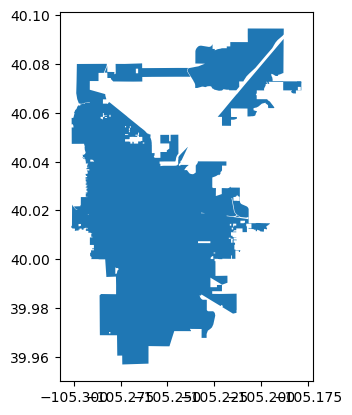

In [29]:
# Download City of Boulder boundary

boundary_url = ("https://gis.bouldercolorado.gov/ags_svr1/rest/services/plan/CityLimits/MapServer/0/query?outFields=*&where=1%3D1&f=geojson")

boundary_path = os.path.join(data_dir, 'city_boundary.geojson')

if os.path.exists(boundary_path):
    boundary_gdf = gpd.read_file(boundary_path)
    print("Data is already downloaded.")
else:
    # Mimic web browser
    user_agent = (
        'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
        'Gecko/20100101 Firefox/81.0'
    )

    # Download GEOJSON
    r = requests.get(url=boundary_url, headers={'User-Agent': user_agent})

    # Read GeoJSON data into a GeoDataFrame
    boundary_geojson_data = r.json()

    # Cache
    boundary_gdf = (gpd.GeoDataFrame
                    .from_features(boundary_geojson_data['features'])
                    .to_file(boundary_path, driver="GeoJSON")
                    )
    
    # Read
    boundary_gdf = gpd.read_file(boundary_path)
    print("Data downloaded and loaded.")

boundary_gdf.plot()

In [60]:
# # Ensure directory is set
# os.chdir(os.path.join(data_dir))

# current_directory = os.getcwd()

# print("Current Working Directory:", current_directory)

In [35]:
# Initialize AppeearsDownloader for MODIS NDVI data
evapot_downloader = etapp.AppeearsDownloader(
    download_key="ecostress-evapotranspiration", # optional
    ea_dir=data_dir,
    product="ECO3ETPTJPL.001",  # from list of APPEEARS datasts
    layer="EVAPOTRANSPIRATION_PT_JPL_ETcanopy",
    start_date="04-01",
    end_date="10-31",
    recurring=True,
    year_range=[2021, 2022],
    polygon=boundary_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(evapot_downloader.data_dir):
    evapot_downloader.download_files()

In [36]:
ecostress_data_path = os.path.join(data_dir, 'ecostress-evapotranspiration', 'ECO3ETPTJPL.001_2021091_to_2022304')

print(ecostress_data_path)

/Users/advythramachandran/earth-analytics/data/urban-forest-traits/data/ecostress-evapotranspiration/ECO3ETPTJPL.001_2021091_to_2022304


In [38]:
def compile_info(path):

    # Generate list of data files
    path_list = glob.glob(
        os.path.join(path, "*.tif")
    )

    path_df = pd.DataFrame({"file_path": path_list})

    # Merge images into a single data array

    doy_start = -25  # the character number of the start of doy in file name
    doy_end = -18  # the character number of the end of doy in file name
    # the other characters after are time in UTC
    scale_factor = 1  # from documentation?

    # For every file (.tif image), add it to the list
    for index, image, in path_df.iterrows():

        # Get date from file name
        doy = image['file_path'][doy_start:doy_end]

        # Define the date variable as the doy in file name
        date = pd.to_datetime(doy, format='%Y%j')

        # Add the dates to the DF
        path_df.loc[index, 'doy'] = doy
        path_df.loc[index, 'date'] = date

    return path_df

image_paths = compile_info(ecostress_data_path)

display(image_paths)

,file_path,doy,date
0,/Users/advythramachandran/earth-analytics/data...,2022163,2022-06-12
1,/Users/advythramachandran/earth-analytics/data...,2022240,2022-08-28
2,/Users/advythramachandran/earth-analytics/data...,2022224,2022-08-12
3,/Users/advythramachandran/earth-analytics/data...,2021156,2021-06-05
4,/Users/advythramachandran/earth-analytics/data...,2022105,2022-04-15
...,...,...,...
80,/Users/advythramachandran/earth-analytics/data...,2022117,2022-04-27
81,/Users/advythramachandran/earth-analytics/data...,2021276,2021-10-03
82,/Users/advythramachandran/earth-analytics/data...,2022157,2022-06-06
83,/Users/advythramachandran/earth-analytics/data...,2021121,2021-05-01


In [39]:
# Test with a subset of the data
image_paths_subset = image_paths.iloc[0:5]
display(image_paths_subset)

,file_path,doy,date
0,/Users/advythramachandran/earth-analytics/data...,2022163,2022-06-12
1,/Users/advythramachandran/earth-analytics/data...,2022240,2022-08-28
2,/Users/advythramachandran/earth-analytics/data...,2022224,2022-08-12
3,/Users/advythramachandran/earth-analytics/data...,2021156,2021-06-05
4,/Users/advythramachandran/earth-analytics/data...,2022105,2022-04-15


In [89]:
def open_data(path_df, diagnostics=False):

    images_list = [] 

    for index, image in path_df.iterrows():
        
        path = image['file_path']

        da = rxr.open_rasterio(path, masked=True)

        # Add date as a coordinate
        date = image['date']
        da = da.assign_coords(date=date)

        # display(da)

        images_list.append(da)

        # Add date as a coordinate

        # Show diagnostic plots for the first image
        if diagnostics==True:

            print(f'Diagnostics for date: {date}')

            display(da)

            crs = da.rio.crs
            print(crs)

            bounds = da.rio.bounds()
            print(bounds)

            # Plots
            da.plot()
            plt.title(date)

            boundary_gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')
            plt.show()

            break

        else:

            print("Loaded")

            continue

    # Reproject match
    target_grid = images_list[0]
    images_reprojected_list = []

    for image in images_list:
        image_reprojected = image.rio.reproject_match(target_grid)

        images_reprojected_list.append(image_reprojected)
            
    
    return images_reprojected_list

# Compare with bounds of the city
city_bbox = boundary_gdf.total_bounds
print(f'city bounds: {city_bbox}')

et_images_list = open_data(image_paths, diagnostics=False)

len(et_images_list)


city bounds: [-105.30145091   39.95691668 -105.17809882   40.09448471]
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded
Loaded


85

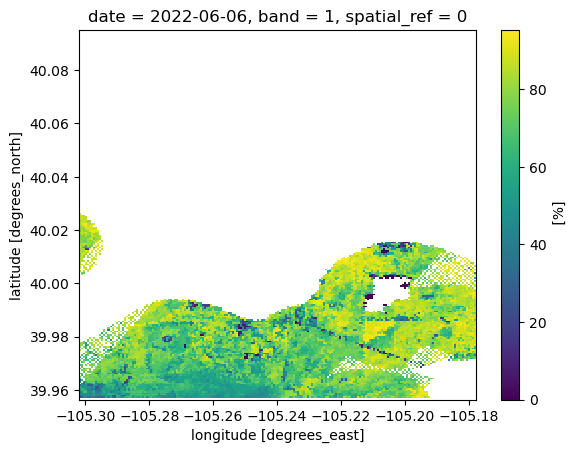

In [91]:
et_images_list[82].plot()

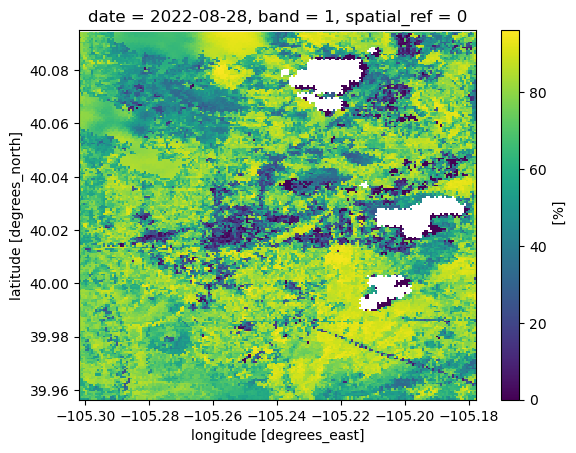

In [93]:
# Combine 
all_dates_da = xr.concat(et_images_list, dim='date')
all_dates_da

all_dates_da[1].plot()

In [97]:
# Take the mean at each pixel

mean_da = all_dates_da.mean(dim='date', skipna=True)

display(mean_da)

<xarray.DataArray (band: 1, y: 220, x: 197)>
array([[[62.247826, 63.493183, 63.448845, ..., 51.436577, 57.916897,
         61.670506],
        [64.71858 , 65.16196 , 64.8582  , ..., 54.216713, 58.55236 ,
         62.4789  ],
        [65.99713 , 66.23787 , 64.08386 , ..., 55.194862, 59.055786,
         62.616497],
        ...,
        [47.250168, 52.30344 , 52.935104, ..., 62.12771 , 63.159237,
         63.377098],
        [46.428974, 49.705494, 49.279408, ..., 65.03614 , 62.176846,
         59.600056],
        [46.832283, 45.816303, 48.20122 , ..., 67.945465, 65.87038 ,
         65.773506]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.2 -105.2 -105.2
  * y            (y) float64 40.09 40.09 40.09 40.09 ... 39.96 39.96 39.96 39.96

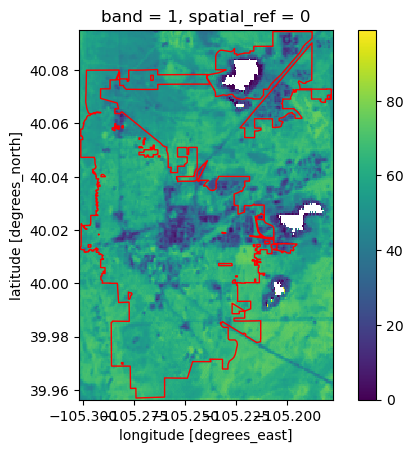

In [101]:
mean_da.plot()

boundary_gdf.plot(ax=plt.gca(), color='none', edgecolor='red')

plt.show()

### Interactive ECOSTRESS Evapotranspiration map

In [118]:
mean_da

<xarray.DataArray (band: 1, y: 220, x: 197)>
array([[[62.247826, 63.493183, 63.448845, ..., 51.436577, 57.916897,
         61.670506],
        [64.71858 , 65.16196 , 64.8582  , ..., 54.216713, 58.55236 ,
         62.4789  ],
        [65.99713 , 66.23787 , 64.08386 , ..., 55.194862, 59.055786,
         62.616497],
        ...,
        [47.250168, 52.30344 , 52.935104, ..., 62.12771 , 63.159237,
         63.377098],
        [46.428974, 49.705494, 49.279408, ..., 65.03614 , 62.176846,
         59.600056],
        [46.832283, 45.816303, 48.20122 , ..., 67.945465, 65.87038 ,
         65.773506]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.2 -105.2 -105.2
  * y            (y) float64 40.09 40.09 40.09 40.09 ... 39.96 39.96 39.96 39.96

In [156]:
ET_plot = (mean_da.sel(band=1).hvplot(cmap='viridis', geo=True, tiles='EsriImagery', alpha=0.7) * boundary_gdf.hvplot(geo=True, fill_alpha=0))

ET_plot_big = ET_plot.opts(width=600, height=600)

hvplot.save(ET_plot_big, 'ET_plot_big.html')

ET_plot_big

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Image.I    :Image   [x,y]   (value)
   .Polygons.I :Polygons   [Longitude,Latitude]

### **Compare urban forest structure to ET**

In [160]:
# Match crs

print(trees_gdf.crs)
print(mean_da.rio.crs)

EPSG:4326
EPSG:4326


In [161]:
from rasterstats import zonal_stats

In [164]:
num_trees_gdf = zonal_stats(trees_gdf.geometry, mean_da, stats=['mean'])

TypeError: invalid path or file: <xarray.DataArray (band: 1, y: 220, x: 197)>
array([[[62.247826, 63.493183, 63.448845, ..., 51.436577, 57.916897,
         61.670506],
        [64.71858 , 65.16196 , 64.8582  , ..., 54.216713, 58.55236 ,
         62.4789  ],
        [65.99713 , 66.23787 , 64.08386 , ..., 55.194862, 59.055786,
         62.616497],
        ...,
        [47.250168, 52.30344 , 52.935104, ..., 62.12771 , 63.159237,
         63.377098],
        [46.428974, 49.705494, 49.279408, ..., 65.03614 , 62.176846,
         59.600056],
        [46.832283, 45.816303, 48.20122 , ..., 67.945465, 65.87038 ,
         65.773506]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.2 -105.2 -105.2
  * y            (y) float64 40.09 40.09 40.09 40.09 ... 39.96 39.96 39.96 39.96

In [153]:
import xml.etree.ElementTree as ET

def load_xml(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Print the XML content in a human-readable format
    xml_str = ET.tostring(root, encoding='utf8').decode('utf8')
    print(xml_str)

    
# Example usage:
xml_file_path = os.path.join(data_dir, 'ecostress-evapotranspiration', 'ecostress-evapotranspiration-ECO3ETPTJPL-001-metadata.xml')
load_xml(xml_file_path)

<?xml version='1.0' encoding='utf8'?>
<ns0:MI_Metadata xmlns:ns0="http://www.isotc211.org/2005/gmi" xmlns:ns2="http://www.isotc211.org/2005/gmd" xmlns:ns3="http://www.isotc211.org/2005/gco" xmlns:ns4="http://www.isotc211.org/2005/gmx" xmlns:ns5="http://www.w3.org/1999/xlink" xmlns:ns6="http://www.opengis.net/gml/3.2" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.isotc211.org/2005/gmi https://ngdc.noaa.gov/metadata/published/xsd/schema.xsd">


  
  <ns2:fileIdentifier>
    <ns3:CharacterString>ecostress-evapotranspiration-ECO3ETPTJPL-001-metadata.xml</ns3:CharacterString>
  </ns2:fileIdentifier>

  
  <ns2:language>
    <ns2:LanguageCode codeList="http://www.loc.gov/standards/iso639-2/php/code_list.php" codeListValue="eng">eng
    </ns2:LanguageCode>
  </ns2:language>

  
  <ns2:characterSet>
    <ns2:MD_CharacterSetCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#MD_CharacterSetCode" codeListValue="UTF8">UTF8
    </n

In [83]:
# Merge NDVI arrays into Dataset and cache result

# Define NDVI processed data path
et_combined_path = os.path.join(project_dir, "et_data.nc")

    # # Merge images into a single data array

    # doy_start = -19  # the character number of the start of doy in file name
    # doy_end = -12  # the character number of the end of doy in file name
    # scale_factor = 10000  # from MODIS data documentation

    # # Define a list
    # ndvi_da_list = []

    # # For every file (.tif image), add it to the list
    # for ndvi_path in ndvi_path_list:
    #     # Get date from file name
    #     doy = ndvi_path[doy_start:doy_end]

    #     # Define the date variable as the doy in file name
    #     date = pd.to_datetime(doy, format='%Y%j')

    #     # Open dataset
    #     da = rxr.open_rasterio(ndvi_path,
    #                            # masked=True changes specific excluded
    #                            # values from the metadata to NaN values
    #                            masked=True).squeeze()

    #     # Prepare to concatenate: Add date dimension and clean up metadata
    #     da = da.assign_coords({'date': date})
    #     da = da.expand_dims({'date': 1})
    #     da.name = 'NDVI'

    #     # Divide by scale factor (see data citation for details)
    #     da = da / scale_factor

    #     # Add the DataArray to the end of the accumulator list
    #     ndvi_da_list.append(da)
    #     print("Added .tif data to data array list.")

    # # Stack arrays into time series
    # ndvi_dataset = xr.combine_by_coords(ndvi_da_list, coords=["date"])
    # print("Stacked arrays into data set.")

    # # Cache the ndvi dataset as a netCDF
    # ndvi_dataset.to_netcdf(path=ndvi_combined_path)
    # print("Created netCDF file.")

Merging and processing data.


[]